In [76]:
# ============================================
# Heart Attack Prediction Study
# Exploratory Data Analysis, Feature Engineering, Classification
# Classification Algorithm - SVM - Gradient Boosting Classifier
# 27/10/2024
# ============================================

from google.colab import drive
drive.mount('/content/drive')

# Import Libraries and Modules
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import warnings
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency

# Setting the seed for reproducibility
random.seed(1)
np.random.seed(1)
sk.random.seed(1)

# Load the data
file_path = '.../Heart Attack Prediction Study/Dataset/heart.csv'
heartData = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
## Exploratory Data Analysis (EDA)

# Display the dataset to get an initial overview of the data
print('\nDataset:')
print(heartData)

# Show descriptive statistics for all columns
print('\nDataset Summary:')
print(heartData.describe(include='all'))

# Display the dimensions of the dataset
print('\nDataset Sizes:')
print(heartData.shape)

# Identify data types of each variable in the dataset
print('\nVariable Types:')
varTypes = [str(dtype) for dtype in heartData.dtypes]
print(varTypes)

# Check for any missing values and print the total count of missing entries
print('\nMissing Values:')
missingValues = heartData.isnull().sum().sum()
print(missingValues)



Dataset:
     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1

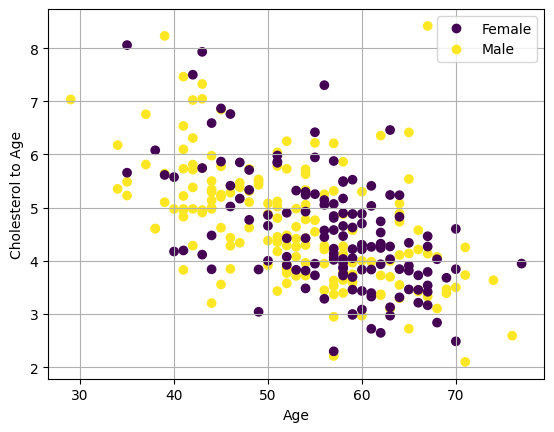

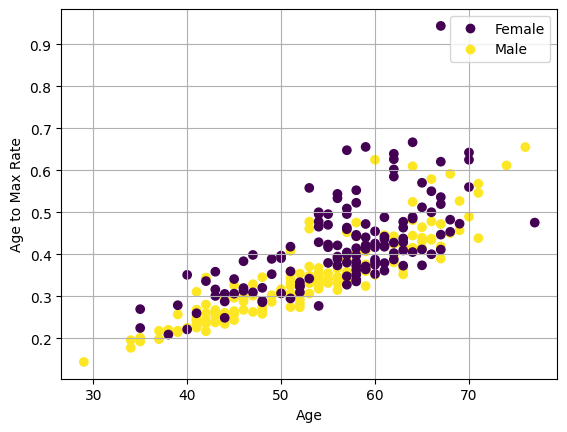

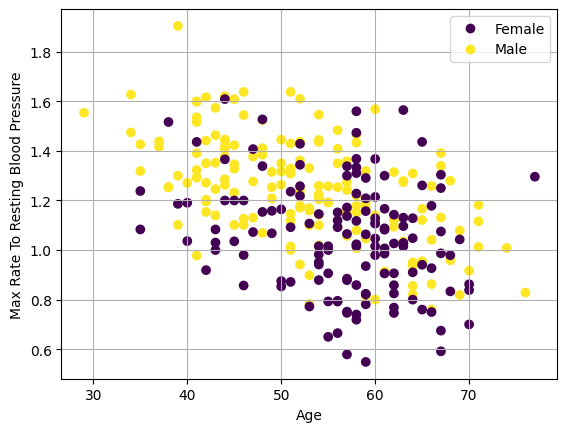

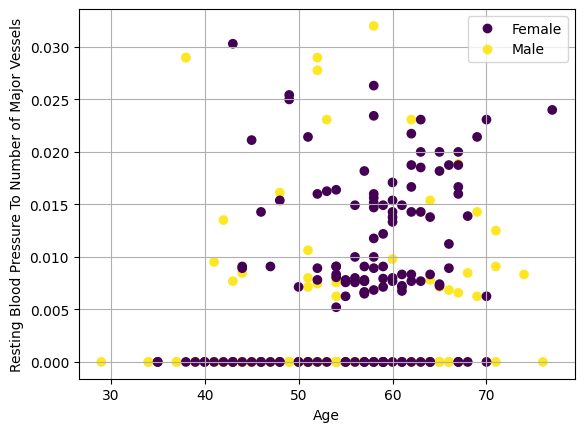

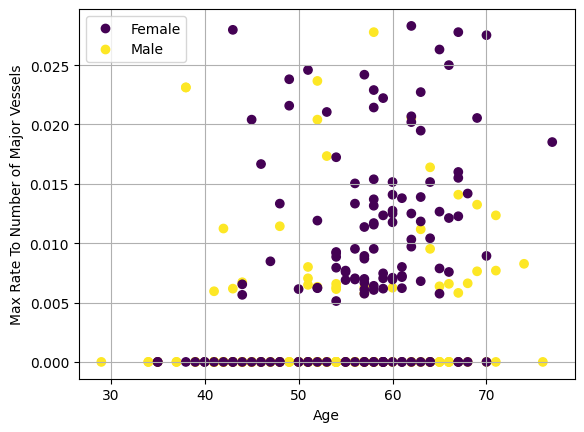

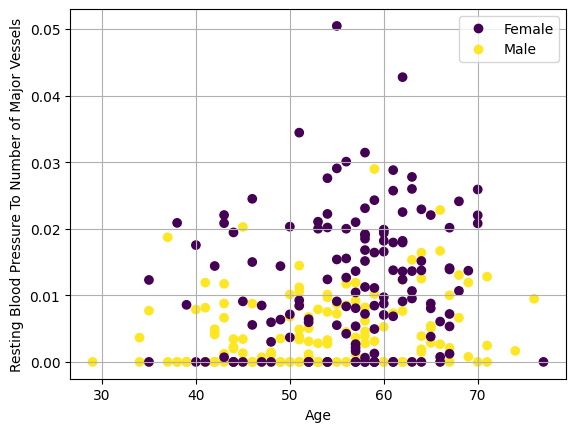

In [78]:
# Feature Engineering for Enhanced Model Insights and Training

# Create a new feature: Cholesterol-to-Age ratio
heartData['CholToAge'] = heartData['chol'] / heartData['age']
plot = plt.scatter(heartData['age'], heartData['CholToAge'], c=heartData['output'])
plt.legend(handles = plot.legend_elements()[0], labels=['Female', 'Male'])
plt.grid(True)
plt.xlabel("Age")
plt.ylabel("Cholesterol to Age")
plt.show()

# Create a new feature: Age-to-Max Heart Rate ratio
heartData['AgeToMaxRate'] = heartData['age'] / heartData['thalachh']
plot = plt.scatter(heartData['age'], heartData['AgeToMaxRate'], c=heartData['output'])
plt.legend(handles = plot.legend_elements()[0], labels=['Female', 'Male'])
plt.grid(True)
plt.xlabel("Age")
plt.ylabel("Age to Max Rate")
plt.show()

# Create a new feature: Max Heart Rate to Resting Blood Pressure ratio
heartData['MaxRateToResting'] = heartData['thalachh'] / heartData['trtbps']
plot = plt.scatter(heartData['age'], heartData['MaxRateToResting'], c=heartData['output'])
plt.legend(handles = plot.legend_elements()[0], labels=['Female', 'Male'])
plt.grid(True)
plt.xlabel("Age")
plt.ylabel("Max Rate To Resting Blood Pressure")
plt.show()

# Create a new feature: Ratio of Major Vessels to Resting Blood Pressure
heartData['MajorVesselsToRestingBP'] = heartData['caa'].astype(str).astype(float) / heartData['trtbps']
plot = plt.scatter(heartData['age'], heartData['MajorVesselsToRestingBP'], c=heartData['output'])
plt.legend(handles = plot.legend_elements()[0], labels=['Female', 'Male'])
plt.grid(True)
plt.xlabel("Age")
plt.ylabel("Resting Blood Pressure To Number of Major Vessels")
plt.show()

# Create a new feature: Ratio of Major Vessels to Max Heart Rate
heartData['MajorVesselsToMaxRate'] = heartData['caa'].astype(str).astype(float) / heartData['thalachh']
plot = plt.scatter(heartData['age'], heartData['MajorVesselsToMaxRate'], c=heartData['output'])
plt.legend(handles = plot.legend_elements()[0], labels=['Female', 'Male'])
plt.grid(True)
plt.xlabel("Age")
plt.ylabel("Max Rate To Number of Major Vessels")
plt.show()

# Create a new feature: ST Depression to Max Heart Rate ratio
heartData['STDepressionToMaxRate'] = heartData['oldpeak'] / heartData['thalachh']
plot = plt.scatter(heartData['age'], heartData['STDepressionToMaxRate'], c=heartData['output'])
plt.legend(handles = plot.legend_elements()[0], labels=['Female', 'Male'])
plt.grid(True)
plt.xlabel("Age")
plt.ylabel("Resting Blood Pressure To Number of Major Vessels")
plt.show()


['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'CholToAge', 'AgeToMaxRate', 'MaxRateToResting', 'MajorVesselsToRestingBP', 'MajorVesselsToMaxRate', 'STDepressionToMaxRate', 'output']


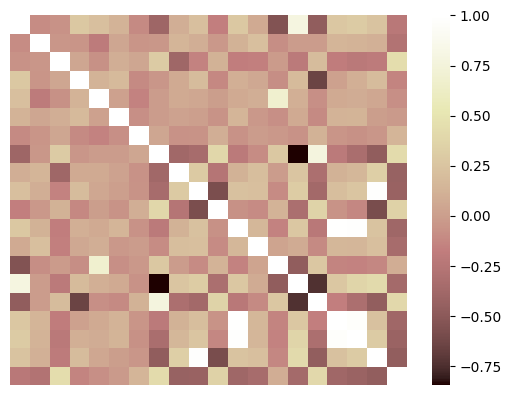

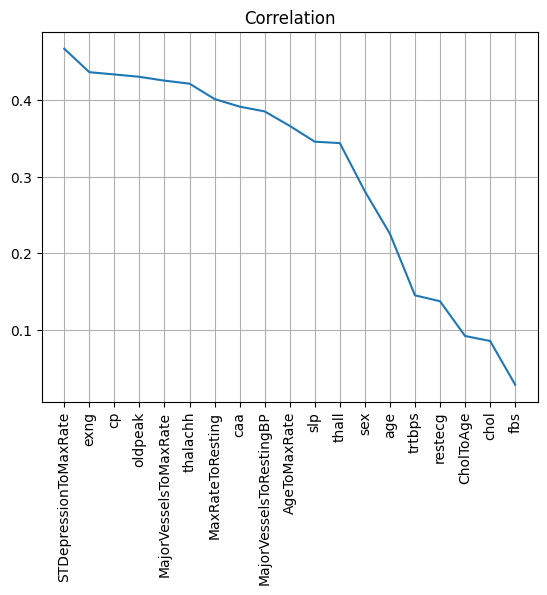

In [79]:
# Correlation Matrix and Feature Importance Analysis
# Arrange columns to have 'output' as the last column for correlation matrix calculation
cols = list(heartData.columns)
cols.remove('output')
position = cols.index('STDepressionToMaxRate')
cols.insert(position + 1, 'output')
heartData = heartData[cols]

# Convert DataFrame to a NumPy array for correlation matrix calculation
heartDataArray = heartData.to_numpy()

# Calculate the correlation matrix
corrCoefMatrix = np.corrcoef(heartDataArray, rowvar=False)

# Confirm the column order and structure
heartData = heartData[cols]
cols = list(heartData.columns)
print(cols)

# Calculate absolute correlations with the target variable
outputCorrelationVector = np.abs(corrCoefMatrix[:, -1])

# Sort feature correlations in descending order for importance analysis
idx = np.argsort(outputCorrelationVector)[::-1]
featImpCorelation = outputCorrelationVector[idx]
featImpLabelsbyCorrelation = np.array(heartData.columns)[idx]

# Exclude 'output' from feature importance visualization
featImpLabelsbyCorrelation = featImpLabelsbyCorrelation[1:]
featImpCorelation = featImpCorelation[1:]

# Visualization of the Correlation Matrix
plt.figure()
sns.heatmap(corrCoefMatrix, cmap='pink')
plt.axis('off')
plt.show()

# Visualization of Feature Importance by Correlation
plt.figure()
plt.title("Correlation")
plt.plot(featImpCorelation)
plt.xticks(ticks=np.arange(len(featImpCorelation)), labels=featImpLabelsbyCorrelation, rotation=90)
plt.grid(True)
plt.show()


In [80]:
# Separate the target variable and predictors
heartData_Response = heartData['output']
heartData_Predictors = heartData.drop(columns='output')

# Initialize and train a Random Forest Classifier with Out-of-Bag score
nTrees = 100
rf = RandomForestClassifier(n_estimators=nTrees, oob_score=True)
rf.fit(heartData_Predictors, heartData_Response)

# Calculate feature importance scores from the trained model
importance = rf.feature_importances_
idx = np.argsort(importance)[::-1]

# Display feature importance in descending order
print("\nFeature importance:")
featImpLabelsbyTreeBagger = []
for i in range(heartData_Predictors.shape[1]):
    ii = idx[i]
    column_name = heartData_Predictors.columns[ii]
    print(f'{column_name}: {importance[ii]}')
    featImpLabelsbyTreeBagger.append(column_name)



Feature importance:
cp: 0.10902716251493395
STDepressionToMaxRate: 0.10190683679774035
MajorVesselsToRestingBP: 0.07743997436334926
thall: 0.07510902886993336
thalachh: 0.07305953032937253
oldpeak: 0.06584391315451886
MaxRateToResting: 0.06526571540843847
MajorVesselsToMaxRate: 0.0651900656413325
AgeToMaxRate: 0.058792765078594204
CholToAge: 0.0470342049853118
age: 0.04544418657695216
caa: 0.04026533234722234
chol: 0.03926130977009288
trtbps: 0.03711924517991963
exng: 0.035193797317854915
slp: 0.027700265924194258
sex: 0.019782480022763765
restecg: 0.011593365549989014
fbs: 0.004970820167485933


In [81]:
pValues = []
featImpLabelsbypVals = list(heartData.columns)

# Compute p-values using Chi-squared test for each feature with respect to the target variable
for varName in heartData.columns:
    contingency = pd.crosstab(heartData['output'], heartData[varName])
    chi2, pVal, _, _ = chi2_contingency(contingency)
    # print(f"{varName} - {pVal:.4f}")
    pValues.append(pVal)

# Sort features by p-values in ascending order
featImp_pValuesOrdered, featImpLabelsbypVals = zip(*sorted(zip(pValues, featImpLabelsbypVals)))

# Convert the sorted tuples back to lists
featImp_pValuesOrdered = list(featImp_pValuesOrdered)
featImpLabelsbypVals = list(featImpLabelsbypVals)

# Remove 'output' from the feature labels and p-values lists
output_index = featImpLabelsbypVals.index('output')
del featImp_pValuesOrdered[output_index]
del featImpLabelsbypVals[output_index]

# Display the feature labels sorted by p-value significance
print(featImpLabelsbypVals)


['thall', 'cp', 'caa', 'exng', 'slp', 'sex', 'oldpeak', 'MajorVesselsToRestingBP', 'MajorVesselsToMaxRate', 'restecg', 'STDepressionToMaxRate', 'thalachh', 'chol', 'age', 'MaxRateToResting', 'AgeToMaxRate', 'trtbps', 'CholToAge', 'fbs']


In [82]:
# Partitioning the dataset into training and test sets
# Define the proportion of data to hold out for testing
holdOutRatio = 0.2

# Split the data into training and test sets based on the specified holdout ratio
trainingData, testData = train_test_split(heartData, test_size=holdOutRatio)


In [83]:
# Model training for SVM classification
# Define predictor feature names for SVM model training
predictor_names = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall',
                   'CholToAge', 'AgeToMaxRate', 'MaxRateToResting', 'MajorVesselsToRestingBP', 'MajorVesselsToMaxRate', 'STDepressionToMaxRate']

# Extract predictors and target variable from the training data
X = trainingData[predictor_names]
y = trainingData['output']

# Initialize the Support Vector Machine (SVM) classifier
classification_SVM = SVC(kernel='linear', C=1, probability=True, class_weight={0: 1, 1: 1})
classification_SVM.fit(X, y)

# Set up K-Fold cross-validation with 5 splits for performance validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
# Generate cross-validation predictions
validation_predictions = cross_val_predict(classification_SVM, X, y, cv=kf)

# Calculate validation accuracy based on cross-validation predictions
validation_accuracy = accuracy_score(y, validation_predictions)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

# Extract predictors from the test dataset
X_test = testData[predictor_names]

# Generate predictions on the test set using the trained SVM model
test_predictions = classification_SVM.predict(X_test)
y_test = testData['output']

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")


Validation Accuracy: 0.8140
Test Accuracy: 0.7869


In [87]:
# Model training for Gradient Boosting Classification
warnings.filterwarnings("ignore", category=FutureWarning)

# Define predictor feature names for training
predictor_names = ['age', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall',
                   'CholToAge', 'AgeToMaxRate', 'MaxRateToResting', 'MajorVesselsToRestingBP', 'MajorVesselsToMaxRate', 'STDepressionToMaxRate']

# Extract predictors and target variable from training data
X_train = trainingData[predictor_names]
y_train = trainingData['output']

# Specify which predictors are categorical
is_categorical_predictor = [False, True, False, False, True, True, False, True, False, True, True, True, False, False, False, False, False, False]
# Convert designated predictors to categorical type
for i, is_cat in enumerate(is_categorical_predictor):
    if is_cat:
        X_train.iloc[:, i] = X_train.iloc[:, i].astype('category')

# Initialize Gradient Boosting Classifier with hyperparameters
model = GradientBoostingClassifier(
    max_depth=168,
    learning_rate=0.1887283195334965,
    n_estimators=21)
model.fit(X_train, y_train)

# Set up K-Fold cross-validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Generate cross-validation predictions
cross_val_predictions = cross_val_predict(model, X_train, y_train, cv=kf)

# Calculate accuracy from cross-validation predictions
accuracy = accuracy_score(y_train, cross_val_predictions)
print(f'Cross-Validation Accuracy: {accuracy * 100:.2f}%')

# Extract predictors and target variable from test data
X_test = testData[predictor_names]
y_test = testData['output']

# Convert categorical predictors in the test data to categorical type
for i, is_cat in enumerate(is_categorical_predictor):
    if is_cat:
        X_test.iloc[:, i] = X_test.iloc[:, i].astype('category')

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Cross-Validation Accuracy: 68.18%
Test Accuracy: 81.97%
